In [19]:
import torch
import yaml 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np

from model.PairVAE import PairVAE
from model.pl_PairVAE import PlPairVAE
from dataset.datasetPairH5 import PairHDF5Dataset


# Params

In [20]:
dossier = "lightning_logs/version_79670/checkpoints/"
fichiers = [f for f in os.listdir(dossier) if os.path.isfile(os.path.join(dossier, f))]

print(fichiers)

['epoch=17-step=88038.ckpt']


In [21]:
path_checkpoint = "lightning_logs/version_79670/checkpoints/epoch=17-step=88038.ckpt"
path_config = "lightning_logs/version_79670/config_model.yaml"

In [22]:
array_valid = np.load("lightning_logs/version_79670/val_indices.npy")
array_valid

array([28857, 18636, 39911, ..., 45126, 37303, 14288])

In [23]:
array_train = np.load("lightning_logs/version_79670/train_indices.npy")
array_train

array([37530, 43734, 45674, ..., 13670, 24217,  5794])

In [24]:
with open(path_config, 'r') as file:
    config = yaml.safe_load(file)

In [25]:
config

{'dataset': {'conversion_dict_path': 'data/conversion_dict_all.json',
  'hdf5_file': 'data/pair_saxs_les_closest_of_concentration.h5',
  'metadata_filters': {'material': ['ag']},
  'requested_metadata': ['shape', 'material'],
  'sample_frac': 1.0,
  'transform': {'q_les': {'PaddingTransformer': {'pad_size': 80, 'value': 0}},
   'q_saxs': {'PaddingTransformer': {'pad_size': 80, 'value': 0}},
   'y_les': {'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 80, 'value': 0}},
   'y_saxs': {'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 80, 'value': 0}}}},
 'devices': '1',
 'model': {'VAE_LES': {'args': None,
   'path_checkpoint': 'lightning_logs/version_79610/checkpoints/epoch=16-step=548607.ckpt',
   'path_config': 'lightning_logs/version_79610/config_model.yaml',
   'vae_class': 'ResVAE'},
  'VAE_SAXS': {'args': None,
   'path_checkpoint': 'lightning_logs/version_79577/checkpoints/epoch=126-step=332232.ckpt',
   'path_config': 'lightning_logs/version_79577/conf

# Model

In [26]:
model = PlPairVAE(config, load_weights_VAE=False)

INIT VAE SAXS
{'dilation': 1, 'down_channels': [64, 128, 256], 'in_channels': 1, 'input_dim': 80, 'latent_dim': 64, 'output_channels': 1, 'strat': 'y', 'up_channels': [256, 128, 64]}
VAE Architecture:
	Input Dimension: 80
	Latent Dimension: 64
	In Channels: 1
	Down Channels: [64, 128, 256]
	Up Channels: [256, 128, 64]
	Output Channels: 1
	Flattened Size: 1280
	Encoder Architecture: Sequential(
  (0): ResidualBlock(
    (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (relu): ReLU()
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (skip_connection): Conv1d(1, 64, kernel_size=(1,), stride=(2,))
  )
  (1): ResidualBlock(
    (conv1): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (relu): ReLU()
    (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (skip_connection): Conv1d(64, 128, kernel_size=(1,), stride=(2,))
  )
  (2): ResidualBlock(
    (conv1): Conv1d(128, 256, kernel_size=(3,), stride=(2,)

In [27]:
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Dataset

In [28]:
dataset = PairHDF5Dataset(
hdf5_file = config["dataset"]["hdf5_file"],
metadata_filters = config["dataset"]["metadata_filters"],
conversion_dict_path = config["dataset"]["conversion_dict_path"],
sample_frac = config["dataset"]["sample_frac"],
transform =  config["dataset"]["transform"],
requested_metadata =  config["dataset"]["requested_metadata"],
)
print("========================================")

Applying filters: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


╒══════════════════════════════════════════════╕
│ Dataset Initialization Info                 │
╞══════════════════════════════════════════════╡
│ File: data/pair_saxs_les_closest_of_concentration.h5 │
│ Total samples: 97841                      │
│ Samples filtered: 48907                   │
│ Requested fraction: 1.0                    │
│ Fractioned samples: 48907                  │
│ Requested metadata: 2                      │


# Plot

In [29]:
def plot(idx_sample):
    one_sample = dataset[idx_sample]
    print(one_sample["metadata"])
    
    one_sample = {k:v.unsqueeze(0) if "data_" in k else v for k,v in one_sample.items()}
    dict_output = model(one_sample)

    mse_values = {}
    for recon_key in ["recon_les","recon_saxs2les"]:
        mse_values[recon_key] = F.mse_loss(one_sample["data_y_les"], dict_output[recon_key]).item()
    
    for recon_key in ["recon_saxs","recon_les2saxs"]:
        mse_values[recon_key] = F.mse_loss(one_sample["data_y_saxs"], dict_output[recon_key]).item()

    dict_print = dict_output
    dict_print["y_saxs"] = one_sample["data_y_saxs"]
    dict_print["y_les"] = one_sample["data_y_les"]
    dict_print.pop("z_les")
    dict_print.pop("z_saxs")
        
    dict_saxs = {k:v for k,v in dict_print.items() if k.endswith("saxs")}
    dict_les = {k:v for k,v in dict_print.items() if k.endswith("les")}

    plt.figure(figsize=(5, 3))
    for i, (key, tensor) in enumerate(dict_saxs.items(), 1):
        if key != "y_saxs":
            label = f"{key} with MSE : {round(mse_values[key],5)}"
        else :
            label = key
        plt.loglog(tensor.detach().numpy().flatten(), label=label)
        plt.title("SAXS")
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 3))
    for i, (key, tensor) in enumerate(dict_les.items(), 1):
        if key != "y_les":
            label = f"{key} with MSE : {round(mse_values[key],5)}"
        else :
            label = key
        plt.plot(tensor.detach().numpy().flatten(), label=label)
        plt.title("LES")
        plt.legend()
    plt.tight_layout()
    plt.show()

## Train

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


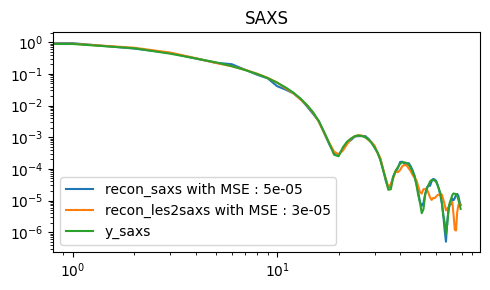

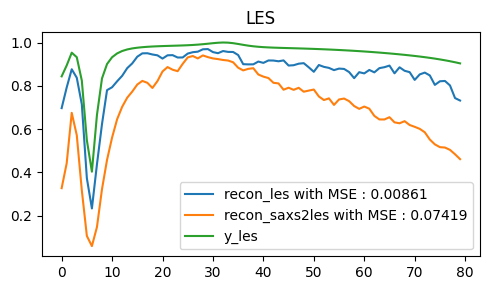

In [30]:
plot(487)

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


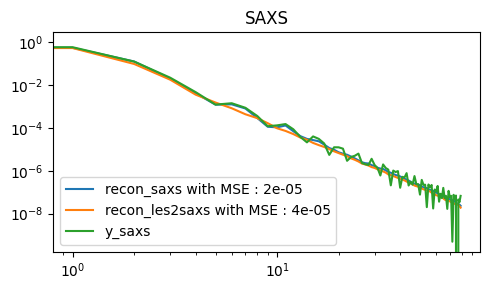

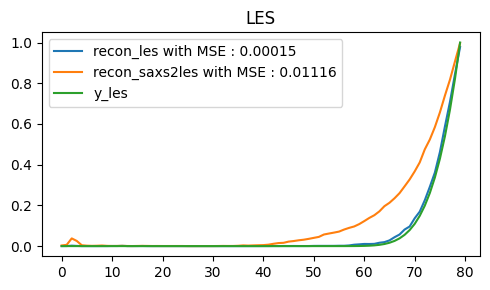

In [31]:
plot(array_train[4944])

## Valid

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


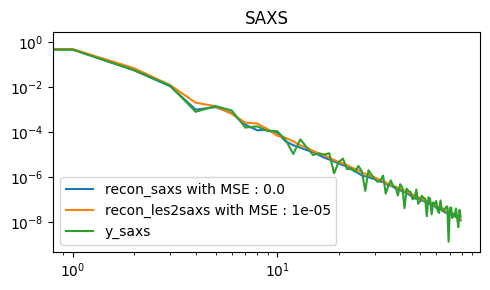

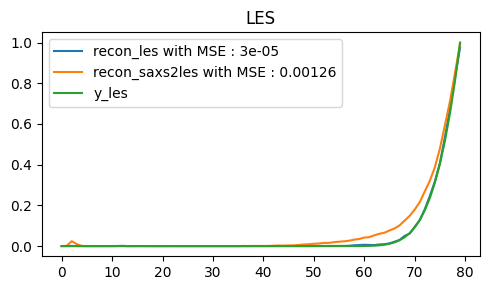

In [32]:
plot(array_valid[8224])

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


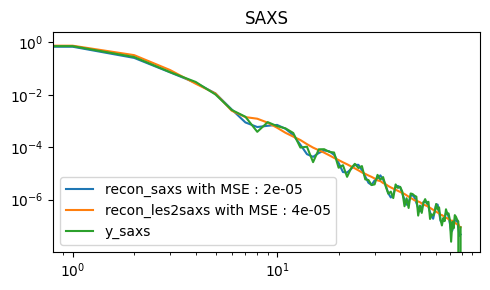

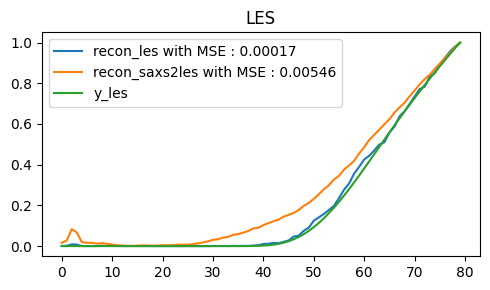

In [33]:
plot(array_valid[45])

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


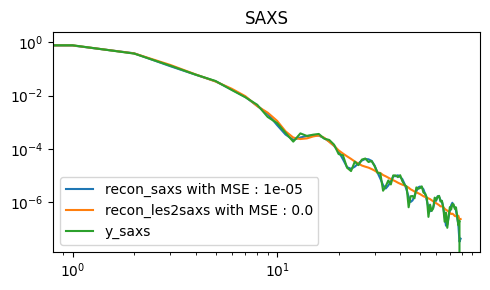

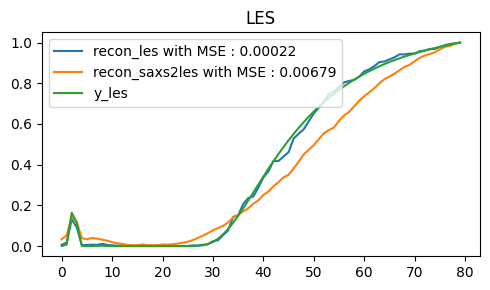

In [34]:
plot(array_valid[111])

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


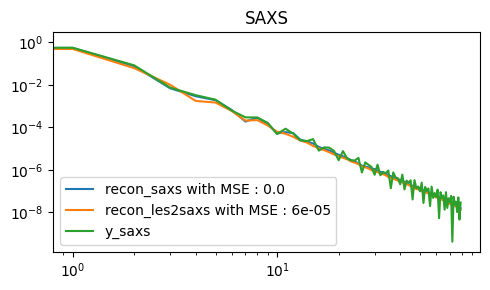

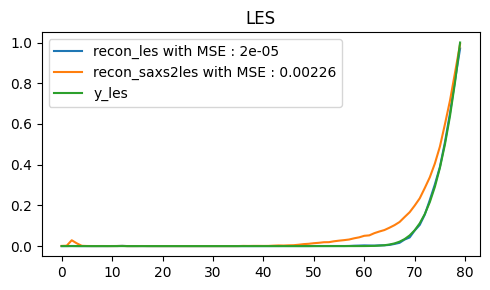

In [35]:
plot(array_valid[32])

{'shape': tensor(0., dtype=torch.float64), 'material': tensor(3., dtype=torch.float64)}


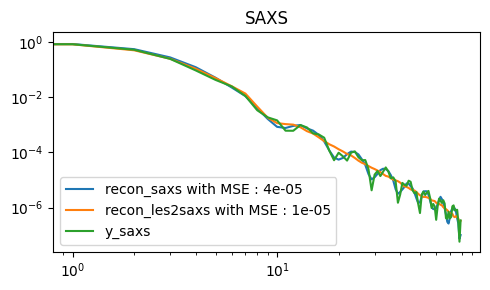

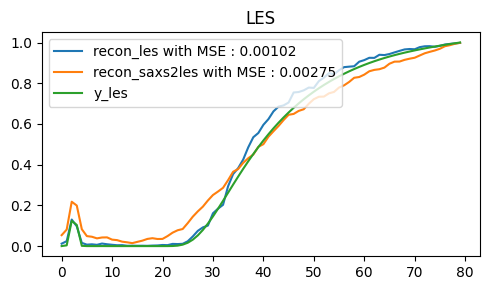

In [18]:
plot(array_valid[1215])